### 集成算法
[推荐阅读 集成算法](www://,l-ensemble.com)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
np.random.seed(seed)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

df = pd.read_csv('./input.csv')


# 获取训练数据
def get_train_test(test_size=0.95):
    '''Split Data into train and test sets'''
    y = 1 *(df.cand_pty_affiliation == 'REP')
    X = df.drop(['cand_pty_affiliation'], axis=1)
    #  onehot
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    
    return train_test_split(X, y, test_size=test_size, random_state=seed)

xtrain, xtest, y_train, y_test = get_train_test()


print("\n Example data:")
df.head()



 Example data:


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [2]:
xtrain.head()

,cycle,transaction_amt,cand_office_st_AK,cand_office_st_AL,cand_office_st_AR,cand_office_st_AZ,cand_office_st_CA,cand_office_st_CO,cand_office_st_CT,cand_office_st_DC,...,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_ZZ,classification_Engineer,classification_Math-Stat,classification_Scientist
56233,2016.0,10.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
99016,2008.0,1000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
87796,2016.0,7.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
44516,2016.0,10.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
66025,2012.0,250.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


* cand_pty_affiliation：我们要预测的指标，共和党或者民主党
* entity_tp：个人还是组织
* classification:领域
* rpt_tp：贡献的大小
* cycle：捐赠在哪年
* transaction_amt：捐献金额

### ROC 和AOU

<img src='11.png'>

<img src='10.png'>

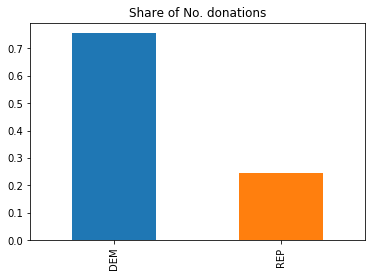

In [3]:
# labels的类别比例大小
df.cand_pty_affiliation.value_counts(normalize=True).plot(kind='bar', title='Share of No. donations')
plt.show()

构建几个基本的决策树模型来看看

In [4]:
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [5]:
def print_graph(clf, features):
    graph = export_graphviz(
        clf,
        label='root',
        proportion=True,
        impurity=False,
        out_file=None,
        feature_names=features,
        class_names={0:'D',1:'R'},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())

Decision tree ROC-AUC score: 0.673


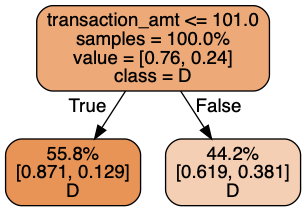

In [6]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=seed)
t1.fit(xtrain,y_train)
p = t1.predict_proba(xtest)[:,1]

print("Decision tree ROC-AUC score: %.3f"%roc_auc_score(y_test, p))
print_graph(t1, xtrain.columns)

改变树的深度试试

3 layer decision tree auc sore 0.772


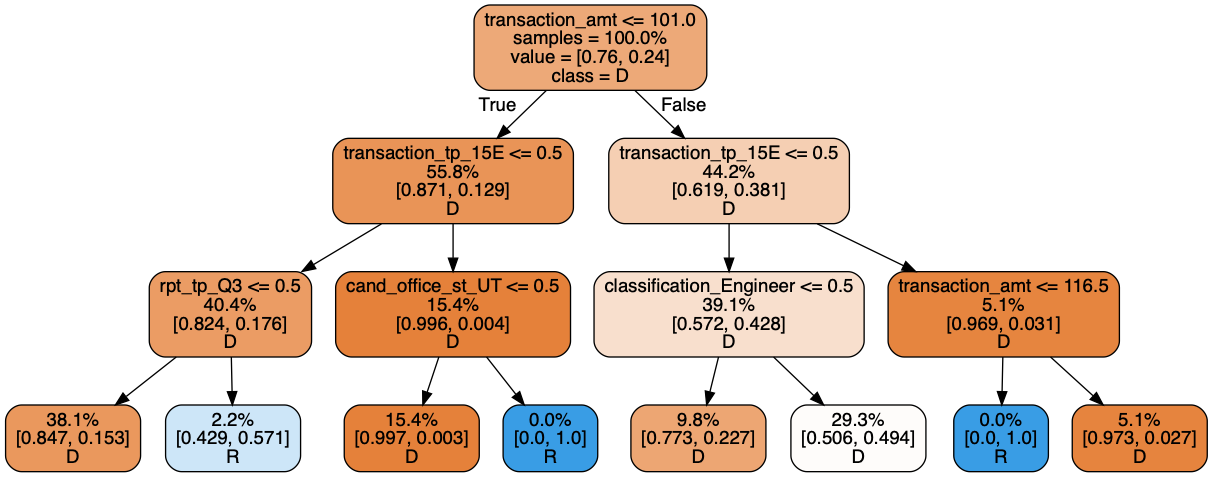

In [8]:
t2 = DecisionTreeClassifier(max_depth=3,random_state=seed)
t2.fit(xtrain,y_train)
p2 = t2.predict_proba(xtest)[:,1]

auc_score = roc_auc_score(y_test, p2)
print("3 layer decision tree auc sore %.3f"% auc_score)
print_graph(t2,xtrain.columns)

比单层的决策树auc分数要高一点了

去掉对结果影响最大的特征再试试

t3 auc socre: 0.772


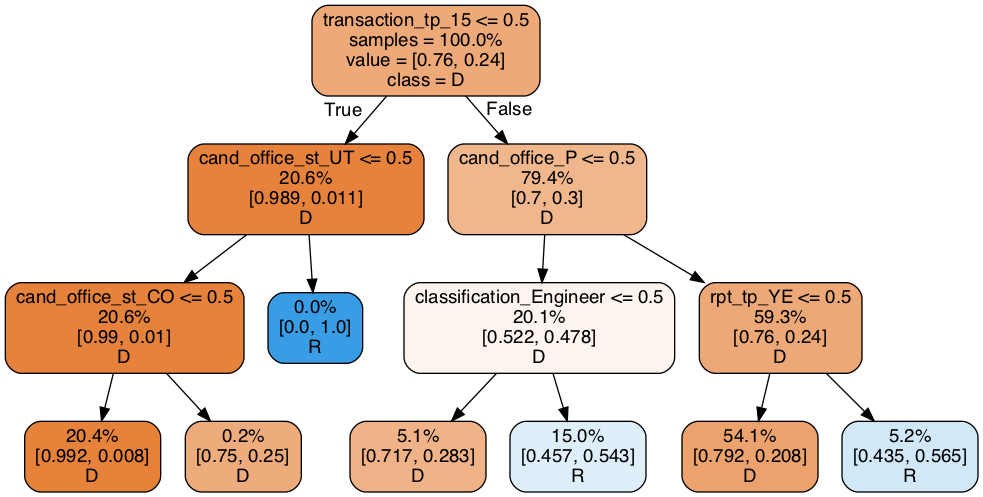

In [11]:
drop = ['transaction_amt']
xtrain_slim = xtrain.drop(drop,1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3,random_state=seed)
t3.fit(xtrain_slim,y_train)
p = t3.predict_proba(xtest_slim)[:,1]

auc_socre = roc_auc_score(y_test, p)
print('t3 auc socre: %.3f' % auc_score)
print_graph(t3, xtrain_slim.columns)

In [13]:
# 综合一下 t2 和t3 
p1 = t2.predict_proba(xtest)[:,1]
p2 = t3.predict_proba(xtest_slim)[:,1]

p = np.mean([p1,p2],axis=0)

print("average of dcTree ROC-AUC socre: %.3f" % roc_auc_score(y_test,p))

average of dcTree ROC-AUC socre: 0.809


以上只是两个决策树的组合
如果有更多个的决策树参与这个过程，就是随机森林了

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=seed
)

rf.fit(xtrain,y_train)
p = rf.predict_proba(xtest)[:,1]

print("RF roc-auc score is: %.3f" % roc_auc_score(y_test,p))

RF roc-auc score is: 0.847


以上结果可以看到 随机森林的分类效果比两颗决策树的组合要强

---
### 如果使用 stacking呢